# Analyse des données extraite via Graal

## Ouverture de data.csv et insertion dans df

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
#Fonction pour clean le data (le plus générale possible)
def cleanData(df,columns,vide):
    #on ajoute le header
    df.columns =columns
    #On récupère que les valeurs entre guillemets
    df= df.applymap(lambda x: re.search(r'(^.*"(.*)\")',str(x)).group(2))

    #Passage NaN au valeur aillant le mot vide
    for column in df.columns[0:]:
        df.loc[df[column]==vide,column]=np.nan
    return df


        
#on transforme en dataframe
df = pd.read_csv("data.csv", header=None)
#Définition du header
columns = ["boat","embarked","sex","age","firstname","lastname","parch","sibsp","ticket","pclass"]    
#indication du mot vide (modulable selon si c'est ?, Unknown,null, NULL etc)
vide = 'null'

df = cleanData(df,columns,vide)
df.head()


,boat,embarked,sex,age,firstname,lastname,parch,sibsp,ticket,pclass
0,NaN,S,male,NaN,Mr. Ingvald Olai Olsen,Hagland,0,1,65303,3
1,NaN,S,female,8.0,Miss. Torborg Danira,Palsson,1,3,349909,3
2,11,NaN,female,22.0,Miss. Alice,Cleaver,0,0,113781,1
3,9,NaN,female,24.0,Miss. Alice,Herman,2.0,1.0,220845,2
4,NaN,S,male,20.0,Mr. Domingos Fernandeo,Coelho,0,0,SOTON/O.Q. 3101307,3


## Ouverture de check.csv

In [126]:
dfSurvived = pd.read_csv("check.csv", header=None)
columns = ["firstname","lastname","survived"]   
dfSurvived = cleanData(dfSurvived,columns,vide)

## Fusion

In [127]:
df = pd.merge(df,dfSurvived, on=['firstname', 'lastname'])
df.head()

,boat,embarked,sex,age,firstname,lastname,parch,sibsp,ticket,pclass,survived
0,NaN,S,male,NaN,Mr. Ingvald Olai Olsen,Hagland,0,1,65303,3,0
1,NaN,S,female,8.0,Miss. Torborg Danira,Palsson,1,3,349909,3,0
2,11,NaN,female,22.0,Miss. Alice,Cleaver,0,0,113781,1,1
3,9,NaN,female,24.0,Miss. Alice,Herman,2.0,1.0,220845,2,1
4,NaN,S,male,20.0,Mr. Domingos Fernandeo,Coelho,0,0,SOTON/O.Q. 3101307,3,0


## Analyses des données

<AxesSubplot:>

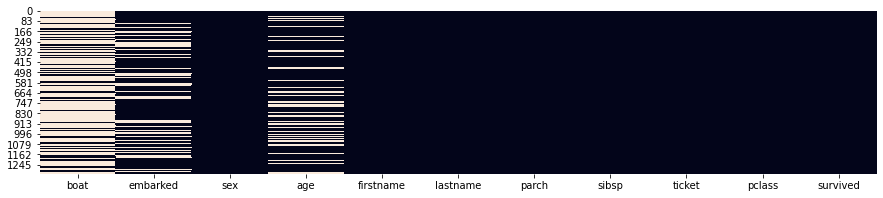

In [128]:
sns.heatmap(df.isnull(), cbar=False)

In [129]:
#transformation des zone numériques (object -> int/float)
df['pclass']=df['pclass'].astype(int)
df['survived']= df['survived'].astype(int)
df['parch']= df['parch'].astype(float)
df['sibsp']= df['sibsp'].astype(float)
df['age']= df['age'].astype(float)
df.describe(include=['O'])

,boat,embarked,sex,firstname,lastname,ticket
count,370,999,1320,1320,1320,1320
unique,73,179,2,1141,875,929
top,4,S,male,Mr. James,Kelly,CA. 2343
freq,32,498,849,15,11,11


In [130]:
df[['pclass', 'survived']].groupby(['pclass'], as_index=False).mean().sort_values(by='survived', ascending=False)

,pclass,survived
0,1,0.618012
1,2,0.429603
2,3,0.255201


In [131]:
df[["sex", "survived"]].groupby(['sex'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sex,survived
0,female,0.723992
1,male,0.189635


In [132]:
df[["sibsp", "survived"]].groupby(['sibsp'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sibsp,survived
1,1.0,0.509434
2,2.0,0.452381
0,0.0,0.345515
3,3.0,0.300000
4,4.0,0.136364
5,5.0,0.000000
6,8.0,0.000000


In [133]:
df[["parch", "survived"]].groupby(['parch'], as_index=False).mean().sort_values(by='survived', ascending=False)

,parch,survived
3,3.0,0.625000
1,1.0,0.588235
2,2.0,0.504425
0,0.0,0.333662
4,4.0,0.166667
5,5.0,0.166667
6,6.0,0.000000
7,9.0,0.000000


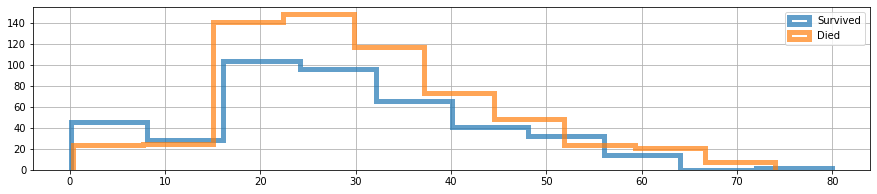

In [134]:
plt.rcParams["figure.figsize"] = (15,3)
#nombre de personnes en vie/morte suivant leur ages
df.loc[df["survived"] == 1,"age"].hist(alpha = 0.7,fill=False, histtype='step',linewidth=5);
df.loc[df["survived"] == 0,"age"].hist(alpha = 0.7,fill=False, histtype='step',linewidth=5).legend(["Survived","Died"]);

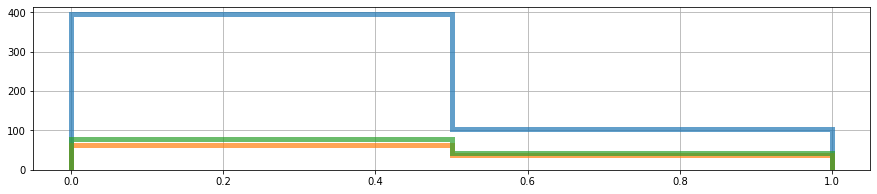

In [135]:
plt.rcParams["figure.figsize"] = (15,3)
#nombre de personnes en vie/morte suivant leur embarcation (pas pertinent mais par curiosité)
df.loc[df["embarked"] == 'S',"survived"].hist(alpha = 0.7,fill=False,range = (0, 1),bins = 2, histtype='step',linewidth=5);
df.loc[df["embarked"] == 'C',"survived"].hist(alpha = 0.7,fill=False,range = (0, 1),bins = 2, histtype='step',linewidth=5);
df.loc[df["embarked"] == 'Q',"survived"].hist(alpha = 0.7,fill=False,range = (0, 1),bins = 2, histtype='step',linewidth=5);

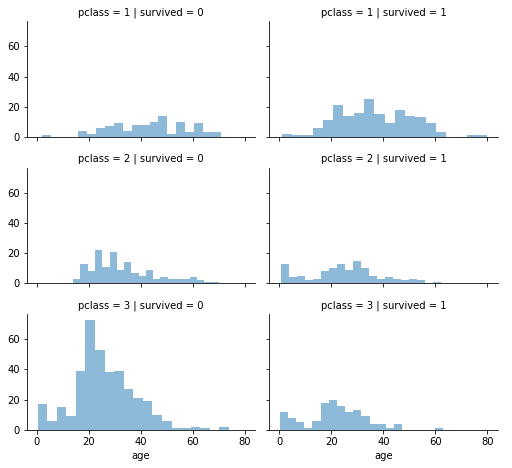

In [136]:
grid = sns.FacetGrid(df, col='survived', row='pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

Pour la classification il faut :
    numéroter les age selon une periode ex : [0,5] = 1  [5,10]=2 ....
    numéroter les fare selon une tranche de prix
    attribuer un chiffre a chaque lettre de embarked
    attribuer un chiffe a chaque sex
    attribuer un chiffre pour la partie nom:
        On peut s'intéresser uniquement au nom de famille a qui on attribut un chiffre
        On  peut s'intéresser uniquement à la classe sociale "miss" , "mister"..
    s'interesser au sibsp, parch de façons différente
        seulement notifier si la personne est seul
        additionner les deux et faire une tranche 0 = 0  [1,3] = 1, [4,6]=2 ....

## transformation des données

In [137]:
def get_title(string):
    import re
    regex = re.compile(r'Mr|Don|Major|Capt|Jonkheer|Rev|Col|Dr|Mrs|Countess|Dona|Mme|Ms|Miss|Mlle|Master', re.IGNORECASE)
    results = regex.search(string)
    if results != None:
        return(results.group().lower())
    else:
        return(str(np.nan))
    
title_dictionary = {
    "capt":"Officer", 
    "col":"Officer", 
    "major":"Officer", 
    "dr":"Officer",
    "jonkheer":"Royalty",
    "rev":"Officer",
    "countess":"Royalty",
    "dona":"Royalty",
    "lady":"Royalty",
    "don":"Royalty",
    "mr":"Mr",
    "mme":"Mrs",
    "ms":"Mrs",
    "mrs":"Mrs",
    "miss":"Miss",
    "mlle":"Miss",
    "master":"Master",
    "nan":"Mr"
}



#si il n'y as pas l'age on met le median selon son titre
title_list = ['Mr','Miss','Mrs','Master', 'Royalty', 'Officer']
def age_nan_replace(means, dframe, title_list):
    for title in title_list:
        temp = dframe['title'] == title #extract indices of samples with same title
        dframe.loc[temp, 'age'] = dframe.loc[temp, 'age'].fillna(means[title]) # replace nan values for mean


In [138]:
#embarked/boat/lastname/ticket n'est pas très pertinent
df = df.drop(columns=['embarked'])
df = df.drop(columns=['boat'])
df = df.drop(columns=['lastname'])
df = df.drop(columns=['ticket'])

#addition de la famille et suppression de parch et sibsp
df["fsize"]= df.apply(lambda x: x.sibsp+x.parch, axis=1)
df = df.drop(columns=['parch', 'sibsp'])


#ajout titre
df["title"] = df["firstname"].apply(get_title)
#mapping titre
df["title"]  = df["title"].map(title_dictionary)
means_title = df.groupby('title')["age"].mean()
#age selon la moyenne par title
age_nan_replace(means_title, df, title_list)



dummies = []
cols = ['pclass', 'sex']
for col in cols:
    dummies.append(pd.get_dummies(df[col]))
titanic_dummies = pd.concat(dummies, axis=1)
df = pd.concat((df,titanic_dummies), axis=1)

df = df.drop(columns=['sex'])
df = df.drop(columns=['firstname'])
df = df.drop(columns=['pclass'])

df.head()

,age,survived,fsize,title,1,2,3,female,male
0,33.412385,0,1.0,Mr,0,0,1,0,1
1,8.000000,0,4.0,Miss,0,0,1,1,0
2,22.000000,1,0.0,Miss,1,0,0,1,0
3,24.000000,1,3.0,Miss,0,1,0,1,0
4,20.000000,0,0.0,Mr,0,0,1,0,1


In [139]:


from sklearn.preprocessing import StandardScaler

numericals_list = ['age']
for column in numericals_list:
    sc = StandardScaler(with_mean=True, with_std=True)
#    print(training_set[column].size)
#    print(test_set[column].size)
    sc.fit(df[column].values.reshape(-1,1))
    df[column] = sc.transform(df[column].values.reshape(-1,1))




from sklearn.preprocessing import LabelEncoder
categorical_classes_list = ['title'] #Pclass is already encoded
#encode features that are cateorical classes
encoding_list = []
for column in categorical_classes_list:
    le = LabelEncoder()
    le.fit(df[column])
    encoding_list.append(df[column].unique())
    df[column] = le.transform(df[column])



In [140]:
df.head()

,age,survived,fsize,title,1,2,3,female,male
0,0.261572,0,1.0,2,0,0,1,0,1
1,-1.673109,0,4.0,1,0,0,1,1,0
2,-0.607269,1,0.0,1,1,0,0,1,0
3,-0.455006,1,3.0,1,0,1,0,1,0
4,-0.759532,0,0.0,2,0,0,1,0,1


In [141]:
df.to_csv('titanic.preprocessing.csv', index=False)

In [142]:
df = pd.read_csv("titanic.preprocessing.csv")

y = df['survived'].values
X = df.drop(['survived'], axis=1).values

In [143]:
from sklearn.naive_bayes import GaussianNB
import re
import pandas as pd
import numpy as np
import itertools
import string

from sklearn.datasets import make_hastie_10_2, make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score, train_test_split, RepeatedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

# evaluate a logistic regression model using repeated k-fold cross-validation
from numpy import mean
from numpy import std
import time
models = []
models.append(('LR', LogisticRegression()))
models.append(('MLR',LogisticRegression(multi_class='multinomial',solver ='newton-cg')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(gamma='auto')))
models.append(('LSVC', LinearSVC(max_iter=3000)))

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
kfold = RepeatedKFold(n_splits=10,n_repeats=3, random_state=7)

In [144]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import time
seed = 7
results = []
names = []
scoring='accuracy'

for name,model in models:
    start_time = time.time()
    cv_results = cross_val_score(model,X, y, cv=kfold, scoring=scoring)
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name )
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)    
    



Time pour MNB   0.07525300979614258
MNB: nan (nan)
Time pour LR   0.5677506923675537
LR: 0.781566 (0.025056)
Time pour MLR   0.5716397762298584
MLR: 0.779798 (0.026600)
Time pour KNN   0.21726202964782715
KNN: 0.772475 (0.031751)
Time pour SVC   1.1516120433807373
SVC: 0.812374 (0.031582)
Time pour LSVC   2.4041669368743896
LSVC: 0.786869 (0.027085)


[Text(1, 0, 'MNB_mic'),
 Text(2, 0, 'LR_mic'),
 Text(3, 0, 'MLR_mic'),
 Text(4, 0, 'KNN_mic'),
 Text(5, 0, 'SVC_mic'),
 Text(6, 0, 'LSVC_mic')]

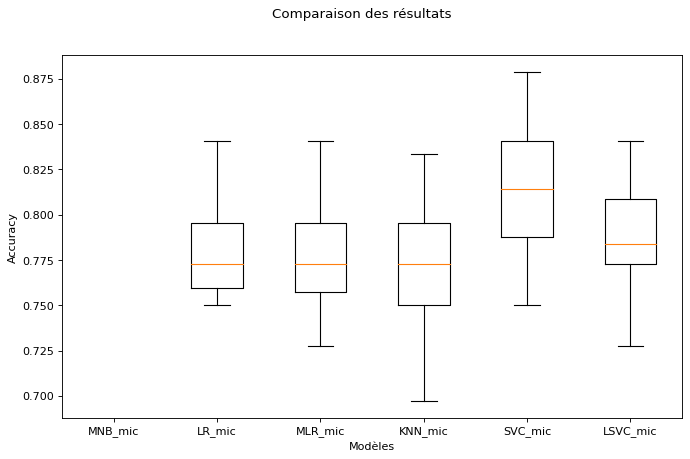

In [145]:
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Comparaison des résultats')
plt.ylabel('Accuracy')
plt.xlabel('Modèles')
ax = fig.add_subplot(111)
plt.boxplot(results,showfliers=False)
ax.set_xticklabels(names)